In [45]:
import gurobipy as gb
import pandas as pd
import numpy as np

from extractor import extract_problem_data

In [46]:
filename = "complexity100_nb_projects5_nb_resources10_slots2_start_time_assignationFalse.txt"


days, slots_per_day, nb_resources, nb_projects, resources, projects = extract_problem_data(filename=f"problems/{filename}")

In [47]:
squash_factor= 1 # value that indicate how much to squash the planning of the project. It need to be >= 1

# calculated data
total_time_slots = days * slots_per_day
BIG_M = max(2*total_time_slots, 99)
max_total_allocation = total_time_slots * nb_resources  # calculate max allocation


In [48]:
env = gb.Env(empty=True)
env.setParam("OutputFlag", 0)
env.start()

model = gb.Model()

model.modelSense = gb.GRB.MINIMIZE  #declare minimization

In [49]:
# variables definition

X = {}
for p in range(nb_projects):
    for r in range(nb_resources):
        for t in range(total_time_slots):
            X[(p, r, t)] = model.addVar(vtype=gb.GRB.BINARY, name=f"X_p{p}_r{r}_t{t}")
S = {}
F = {}
for p in range(nb_projects):
    S[(p)] = model.addVar(vtype=gb.GRB.INTEGER, lb=0, ub=total_time_slots, name=f"S_p{p}")
    F[(p)] = model.addVar(vtype=gb.GRB.INTEGER, lb=0, ub=total_time_slots, name=f"F_p{p}")


Y = model.addVar(vtype=gb.GRB.INTEGER, lb=0, ub=total_time_slots, name=f"Y")

for v in model.getVars():
    print(v.varName)

In [50]:
# constraint 1
# Define constraint: Total working time for each project respect the request
for p in range(nb_projects):
    model.addConstr(sum(X[(p, r, t)] for r in range(nb_resources) for t in range(total_time_slots)) == projects[p].requested_slots)
    
# constraint 2
# constraints no double booking
for r in range(nb_resources):
    for t in range(total_time_slots):
        model.addConstr(sum(X[(p, r, t)] for p in range(nb_projects)) <= 1)

# constraint 3
# on each project only some resources can work on it (the one that are assigned to the project)
for project in projects:
    for resource in resources:
        if(not project.is_resource_assigned(resource)):
            for t in range(total_time_slots):
                model.addConstr(X[project.id, resource.id, t] == 0)
                
                
# constraint 2
for p in range(nb_projects):
    for r in range(nb_resources):
        for t in range(total_time_slots):
            model.addConstr(t * X[(p, r, t)] <= F[p])

# constraint 3
for p in range(nb_projects):
    for r in range(nb_resources):
        for t in range(total_time_slots):
            model.addConstr(S[p] <= t*X[(p, r, t)]+(1-X[(p, r, t)])*BIG_M)

# constraint 4
# constraint assign lower bound of y
for p in range(nb_projects):
    model.addConstr(F[p] <= Y)

# constraint 5
for p in range(nb_projects):
    model.addConstr(F[p]-S[p]+1 <= projects[p].requested_slots*squash_factor)



# constraint 8
# each task are planned to do not start before some specific time
for p in range(nb_projects):
    model.addConstr(S[p] >= projects[p].non_start_before)
    
# constraint 9
# each task are planned to do not finish after some specific time
for p in range(nb_projects):
    model.addConstr(F[p] <= projects[p].non_end_after)

    

In [51]:
model.setObjective(Y, gb.GRB.MINIMIZE)

In [52]:
print("Variables: ",model.NumVars)
print("Constraints: ",model.NumConstrs)

Variables:  0
Constraints:  0


In [53]:
model.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297 rows, 111 columns and 632 nonzeros
Model fingerprint: 0x35ff0ee7
Variable types: 0 continuous, 111 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


In [54]:
print(f"Solver runtime: {model.Runtime} seconds\n\n")

Solver runtime: 0.009137868881225586 seconds


In [55]:
# Write the result on the solution file


from Allocation import Allocation
from typing import List

# write the solution in the file
output_file = f"solutions/{filename}"

# Check the status of the model
status = model.Status
if status == gb.GRB.INFEASIBLE:
    output_file = f"solutions/infeasible/{filename}"

# Open the file in write mode
with open(output_file, "w") as file:   
    if status == gb.GRB.INFEASIBLE:
        file.write("Model is infeasible\n")
    elif status == gb.GRB.UNBOUNDED:
        file.write("Model is unbounded\n")
    elif status == gb.GRB.INF_OR_UNBD:
        file.write("Model is infeasible or unbounded\n")
    elif status == gb.GRB.OPTIMAL:
        # Solution found and is optimal
        file.write("Optimal solution found\n")
    
        # Check the number of solutions
        sol_count = model.SolCount
        file.write(f"Number of solutions found: {sol_count}\n")
        file.write(f"Objective value: {model.ObjVal}\n")
        file.write(f"Solver runtime: {model.Runtime:f} seconds\n\n")
        
        
        allocations: List[Allocation]= []
        for project in projects:
            for resource in project.assigned_resources:
                for t in range(int(Y.x)):
                    if(X[(project.id, resource.id, t)].x == 1.0):
                        allocations.append(Allocation(project, resource, t)) # this update the two collections in project and resource to plan the schedule
        
        for project in projects:
            project.calculate_real_schedule() # calculate real_start and real_end
            
        file.write(f"PROJECT SCHEDULE, nb_projects: {len(projects)}\n")
        for project in projects:
            file.write(f"Project_ID: {project.id}, resources_used: {len(project.allocations)}, requested_slots: {project.requested_slots}\n")
            for resource, value in project.allocations.items():
                file.write(f"Resource: {resource.id}, working: {value}\n")
            file.write("\n")
    
        # Resource POV allocation
        file.write(f"RESOURCE ALLOCATION, nb_resources: {len(resources)}\n")
        for resource in resources:
            file.write(f"Resource_ID: {resource.id}, allocations: {len(resource.allocations)}\n")
            for t in resource.allocations:
                file.write(f"t: {t}, project: {resource.allocations[t].id}\n")
            file.write("\n")      

    else:
        file.write(f"Optimization was stopped with status ={status}\n",)

# Code to try to show a schedule in one graph

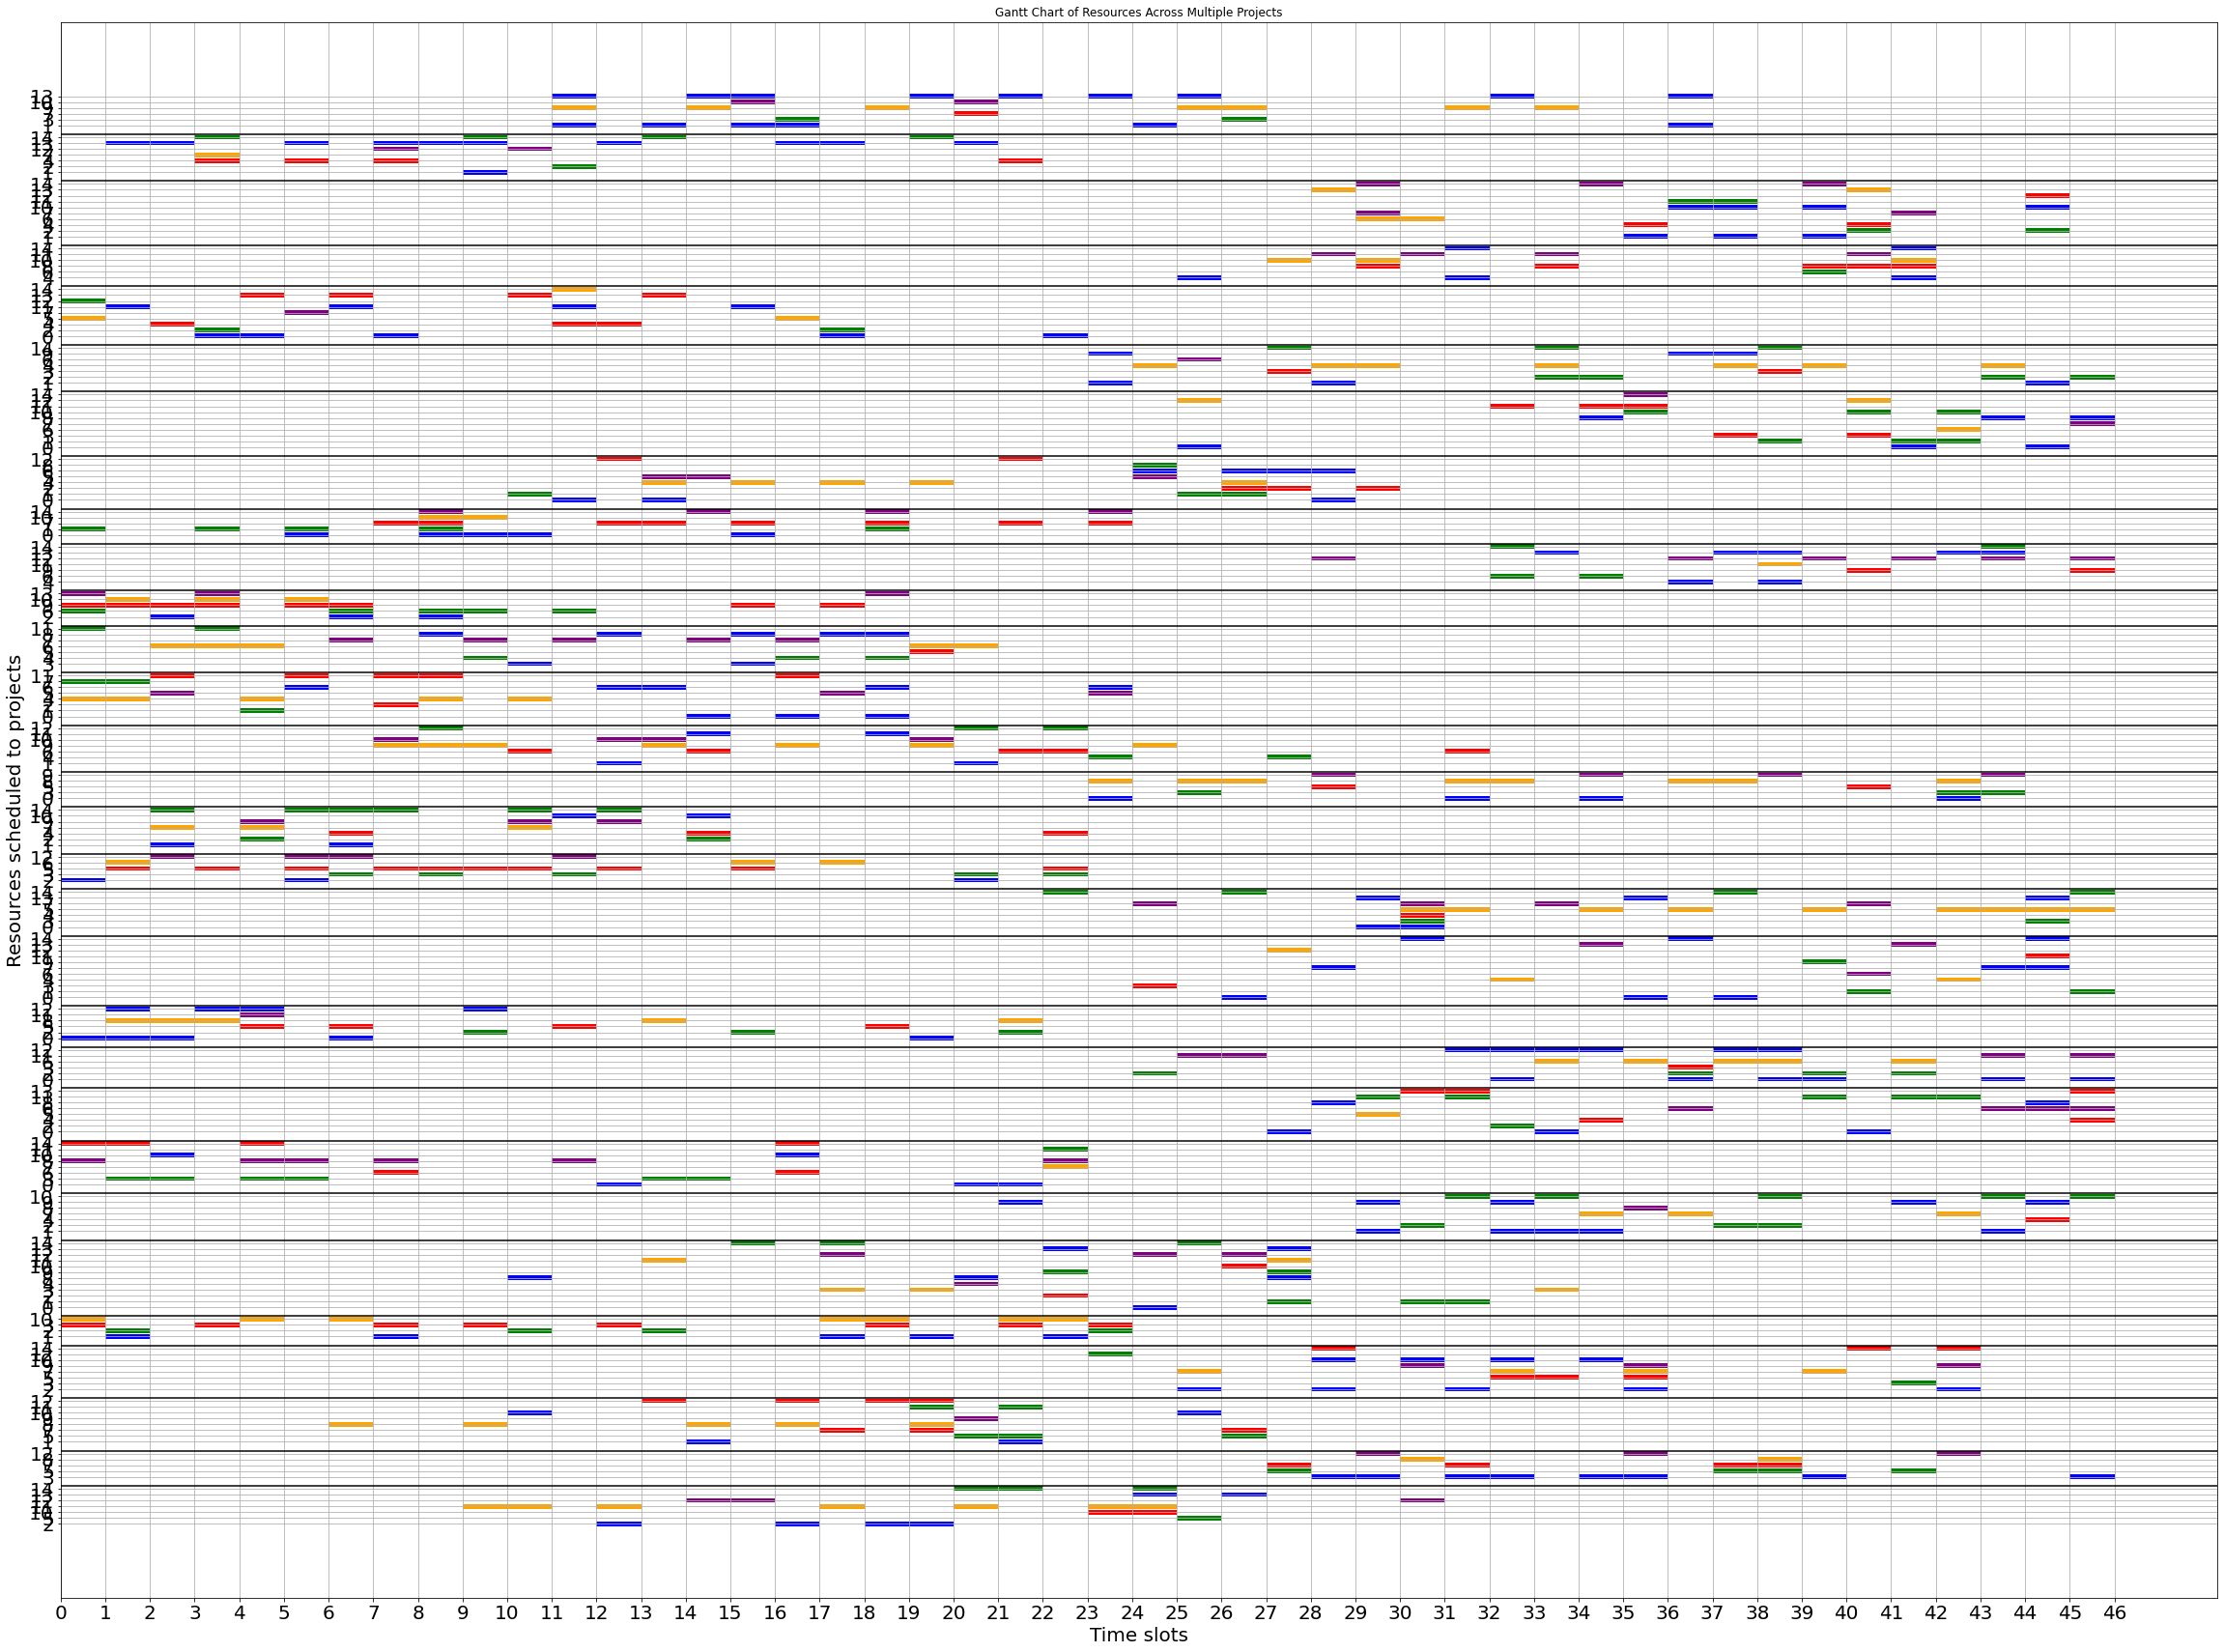

In [27]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(40, 30))
fig.set_facecolor('white')  # Set the background color of the plot to white

y_offset = 0
colors = ['blue', 'green', 'red', 'orange', 'purple']  # Define a palette of colors

y_labels = []  # List to store y-axis labels
y_positions = []  # List to store y-axis label positions

for project in reversed(projects):
    data = {f"{resource.id}": slots for resource, slots in project.allocations.items()}
    y_pos = np.arange(len(data)) + y_offset

    for i, (resource, slots) in enumerate(data.items()):
        color = colors[i % len(colors)]
        for slot in slots:
            plt.barh(y_pos[i], 1, left=slot, align='center', color=color)
        y_labels.append(resource)  # Append the resource name to y_labels
        y_positions.append(y_pos[i])  # Append the y-axis position

    # Updating y_offset for the next project
    y_offset += len(data) + 1  # Adding an extra space to separate projects
    if project.id != 0:
        plt.axhline(y=y_offset - 1.5, color='black', linestyle='-')  # Separating line for projects

# Set the y-axis labels
plt.yticks(y_positions, labels=y_labels)
plt.yticks(fontsize=20) 

# Set the x-axis labels
x_ticks = np.arange(0, int(Y.x)+1, 1)  # Set x-ticks from 0 to 20 at intervals of 1
plt.xticks(x_ticks, fontsize=20)


# Adding labels and title
plt.xlabel('Time slots', fontsize=20)
plt.ylabel('Resources scheduled to projects', fontsize=20)
plt.title('Gantt Chart of Resources Across Multiple Projects')
plt.grid(True)


# Show plot
plt.show()


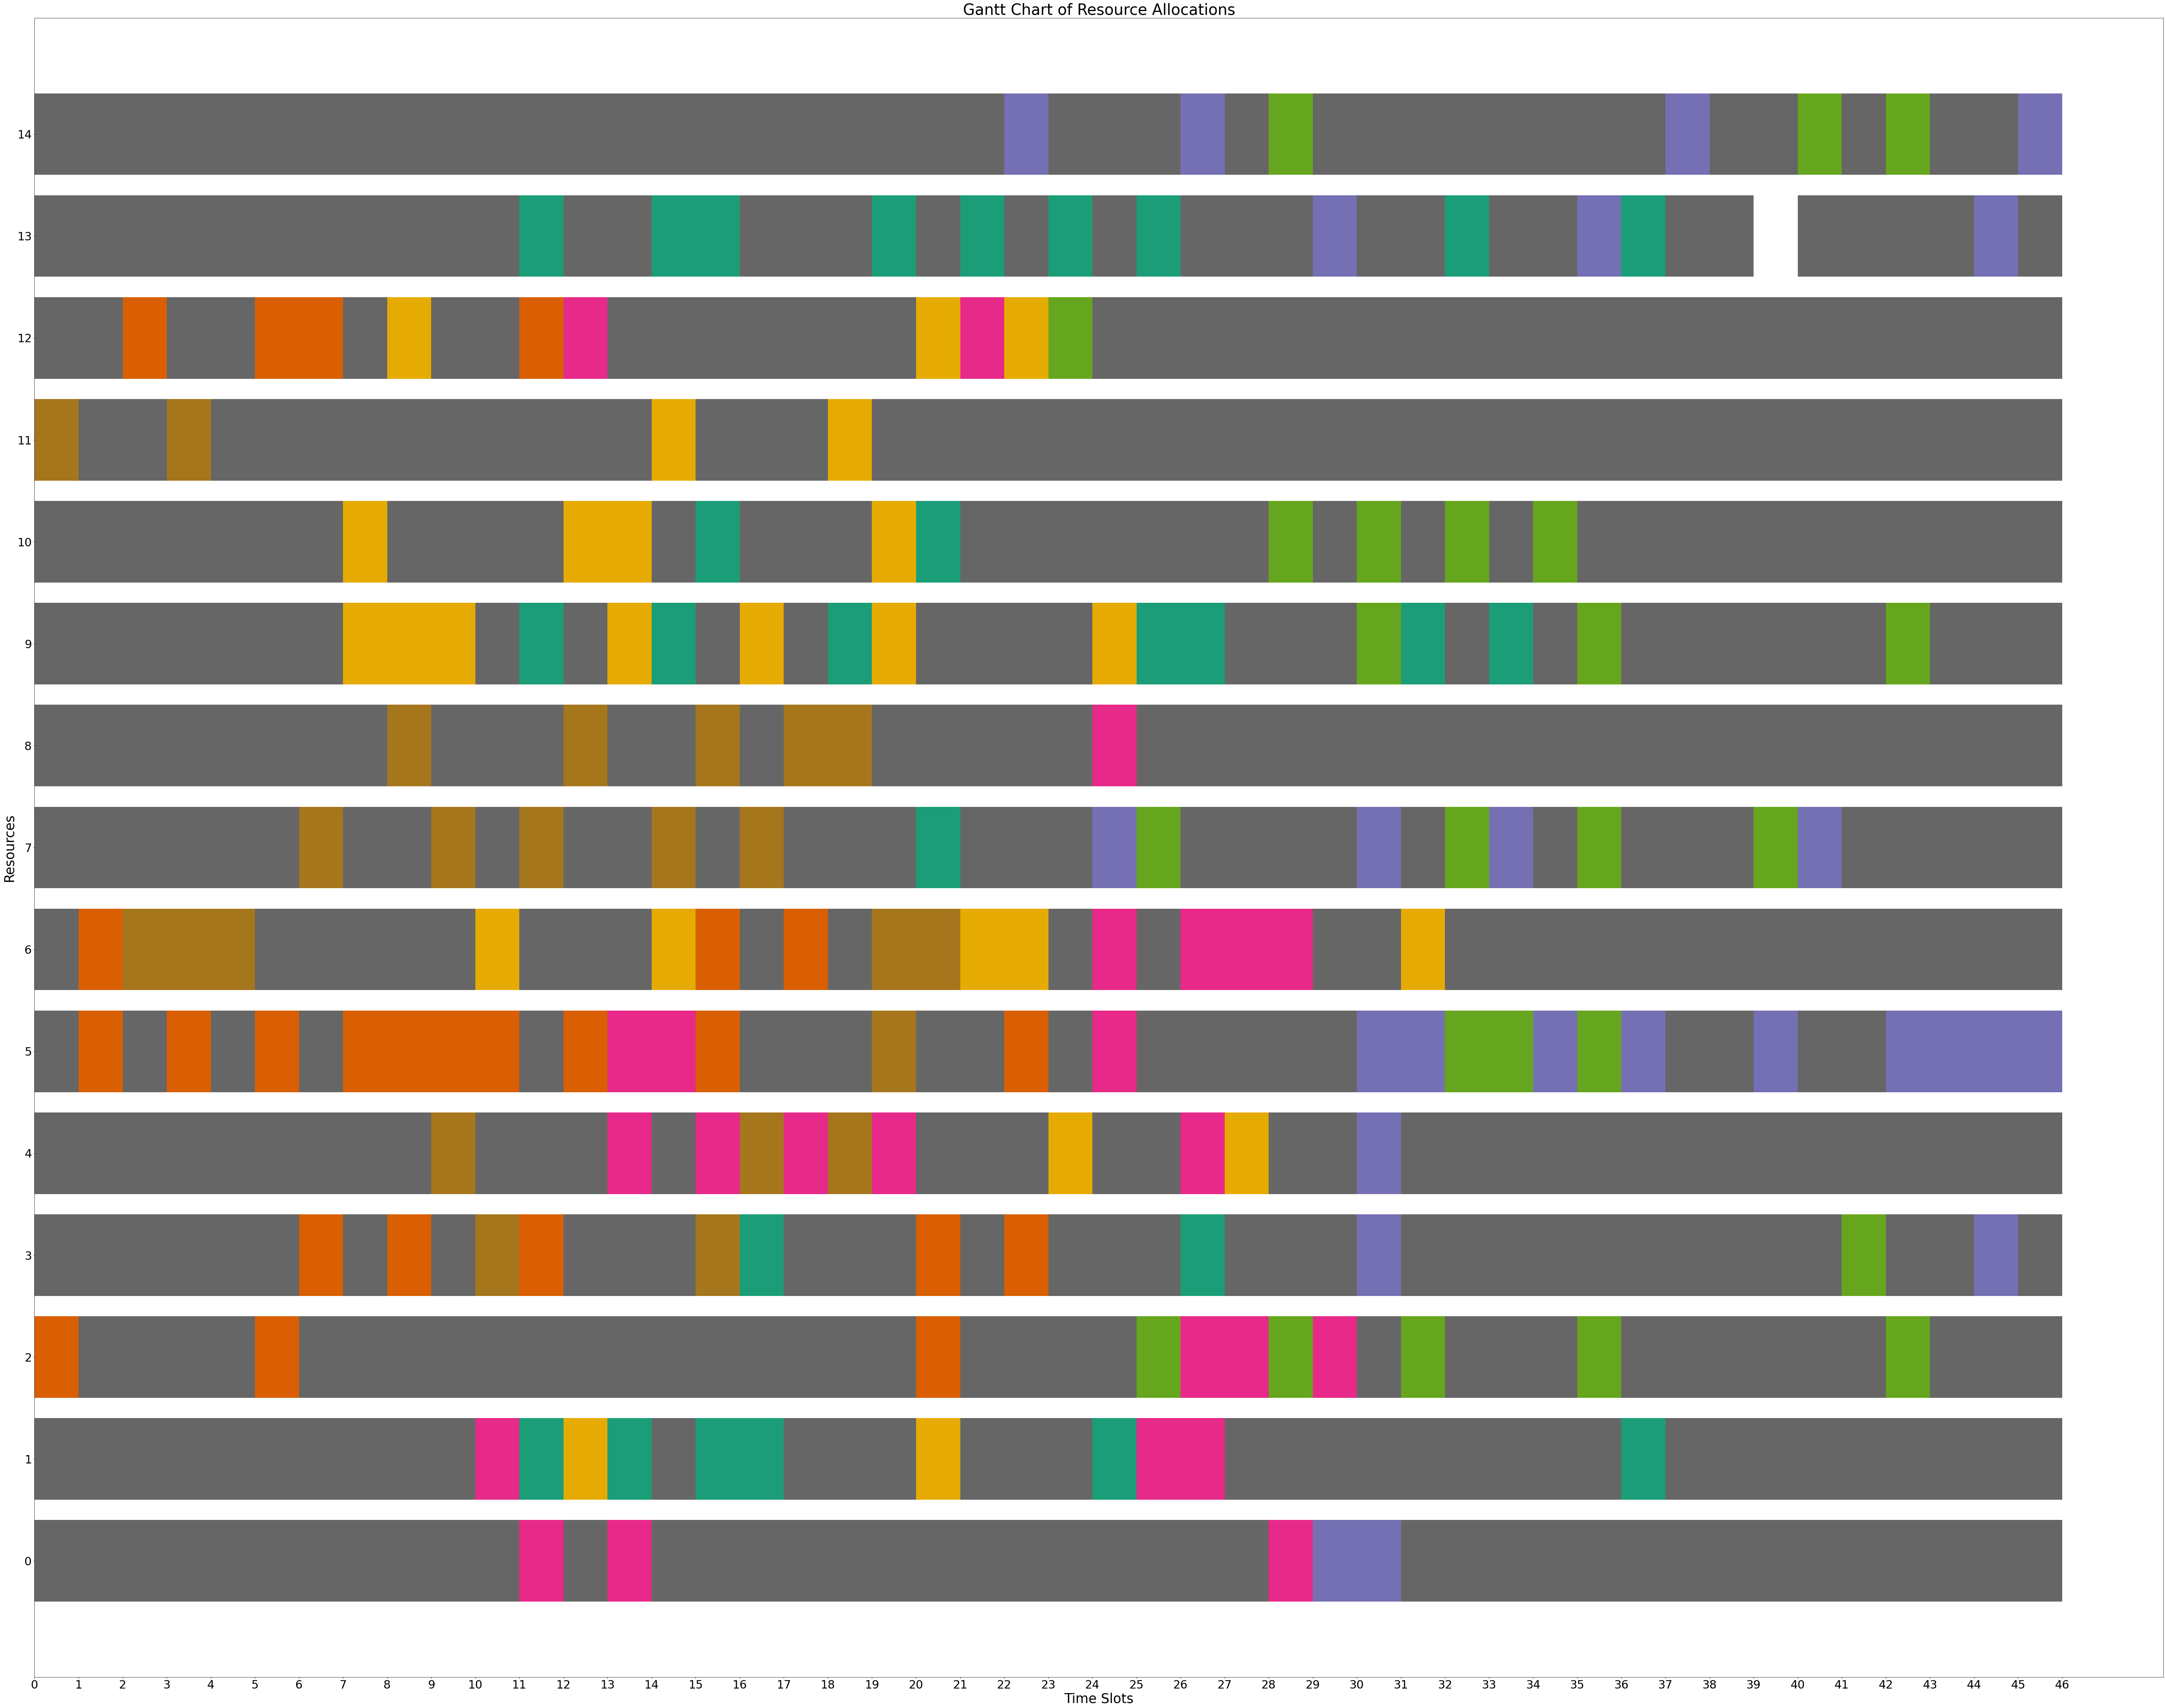

In [28]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np

allocations = {}
for resource in resources:
    allocations[resource] = []
    for k, v in resource.allocations.items():
        allocations[resource].append((v, k))

# Create a list of unique projects
unique_projects = set()
for resource_allocations in allocations.values():
    for project, _ in resource_allocations:
        unique_projects.add(project)

colors = colormaps.get_cmap('Dark2')

# Create a dictionary to map each project to a color
project_colors = {project: colors(i) for i, project in enumerate(unique_projects)}


# Create the Gantt chart
fig = plt.figure(figsize=(100, 80))
fig.set_facecolor('white')  # Set the background color of the plot to white
y_pos = np.arange(len(resources))

for i, resource in enumerate(resources):
    for project, slot in allocations[resource]:
        plt.barh(y_pos[i], 1, left=slot, align='center', label=project, color=project_colors[project], linewidth=3)

# Add labels and title
plt.xticks(np.arange(0, int(Y.x)+1, 1)  , fontsize=30)
plt.yticks(y_pos, [resource.id for resource in resources], fontsize=30)

plt.xlabel('Time Slots', fontsize=35)
plt.ylabel('Resources',  fontsize=35)
plt.title('Gantt Chart of Resource Allocations', fontsize=40)

#plt.legend()

plt.show() 

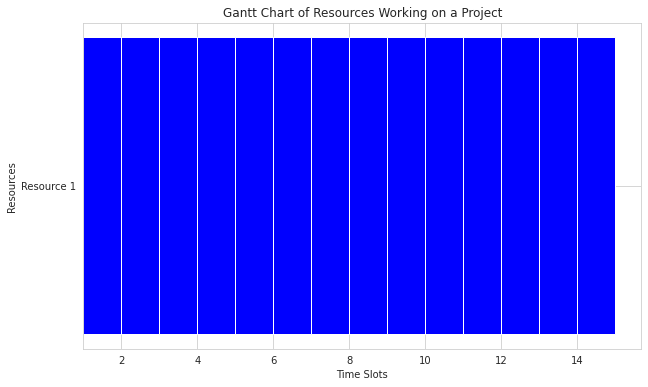

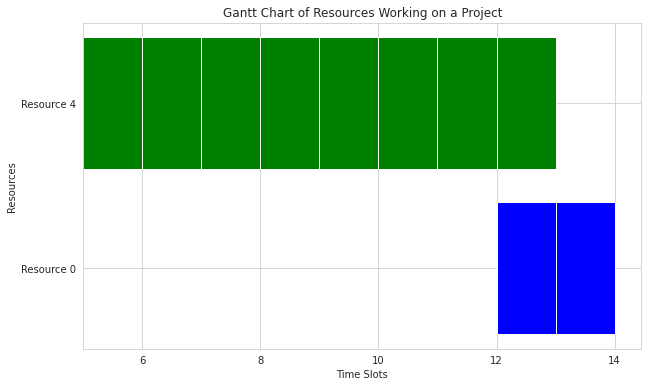

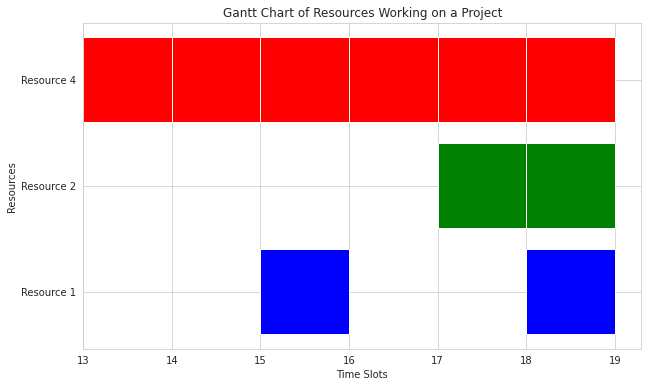

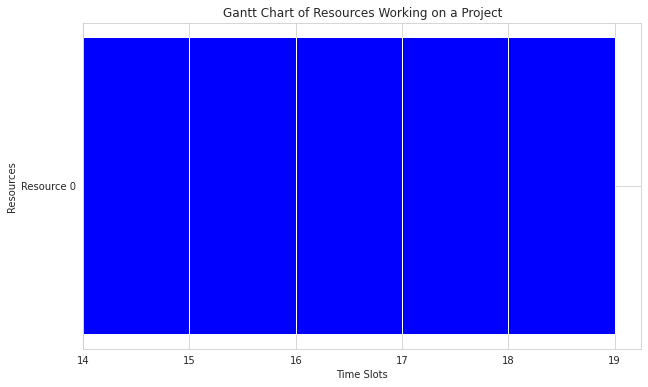

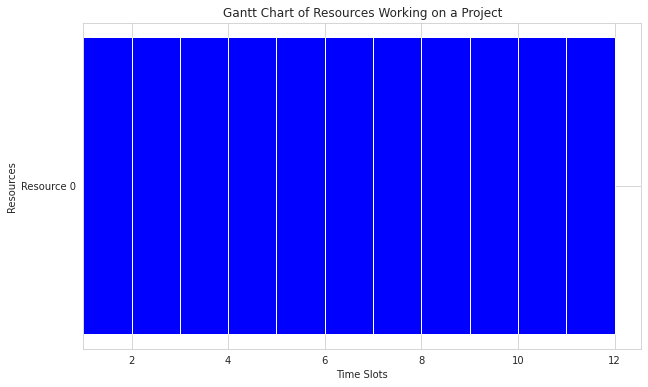

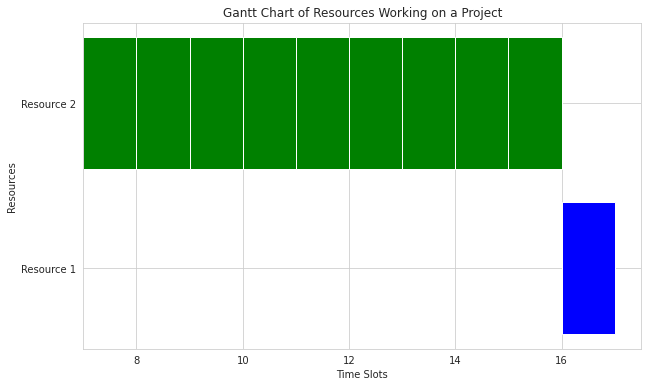

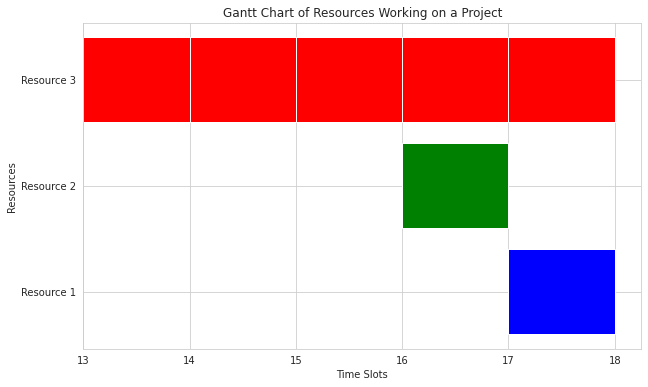

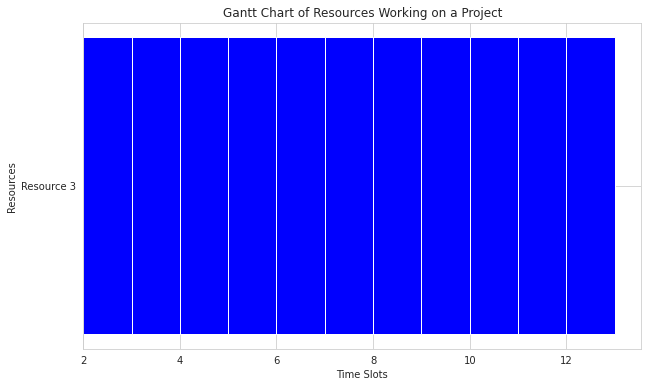

In [12]:
# project by project scheduling view

for project in projects:
    data = {}
    for resource, value in project.allocations.items():
        data[f"Resource {resource.id}"] = value
    resource_slots = {
        "Resource A": [2, 3, 4, 5, 6],
        "Resource B": [5, 6, 7],
        "Resource C": [8, 9, 10, 11, 12, 13, 14]
    }
    
    # Preparing data for Gantt chart
    y_pos = np.arange(len(data))
    
    # Plotting the Gantt chart
    plt.figure(figsize=(10, 6))
    colors = ['blue', 'green', 'red']  # Define different colors for each resource
    
    for i, (resource, slots) in enumerate(data.items()):
        for slot in slots:
            plt.barh(y_pos[i], 1, left=slot, align='center', color=colors[i])
    
    # Adding labels and title
    plt.yticks(y_pos, list(data.keys()))
    plt.xlabel('Time Slots')
    plt.ylabel('Resources')
    plt.title('Gantt Chart of Resources Working on a Project')
    plt.grid(True)
    
    # Show plot
    plt.show()
